**CS-7643 - Deep Learning - Summer 2024 - Final Project - news_dataset_finetuning.ipynb**

**Group - Big Daaata**

Use SoTA models to the test on a News Category Classification dataset and compare the performance of a fine-tuned model against an adapter-based model. Being a Kaggle dataset from real-world data, it will help us quantify the advantages, if any, of the adapter-based models in a practical context.

This notebook has code to run finetuning experiments for SOTA models - 
* distilbert-base-uncased
* google/electra-small-discriminator
* facebook/bart-base
* google/electra-base-discriminator

# Installs

In [6]:
!pip3 install datasets
!pip3 install evaluate
!pip3 install transformers
!pip3 install adapters
!pip3 install mlflow

# Plots

In [7]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_metric
import numpy as np
import mlflow
from transformers import TrainerCallback

# Load the dataset
data_path = '/content/drive/MyDrive/CS7643-final-project/News_Category_Dataset_v3.json' # set path to datset
df = pd.read_json(data_path, lines=True)

# Keep relevant columns
df = df[['category', 'headline']]


label_mapping = {label: idx for idx, label in enumerate(df['category'].unique())}
df['label'] = df['category'].map(label_mapping)

# Split into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'])

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['headline', 'label']])
val_dataset = Dataset.from_pandas(val_df[['headline', 'label']])
test_dataset = Dataset.from_pandas(test_df[['headline', 'label']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Check dataset
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['headline', 'label', '__index_level_0__'],
        num_rows: 150858
    })
    validation: Dataset({
        features: ['headline', 'label', '__index_level_0__'],
        num_rows: 16763
    })
    test: Dataset({
        features: ['headline', 'label', '__index_level_0__'],
        num_rows: 41906
    })
})


In [8]:
import torch
import numpy as np
import pandas as pd
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import TrainerCallback
import datasets
import matplotlib.pyplot as plt

# Define model names
model_names = ['distilbert-base-uncased', 'google/electra-small-discriminator', 'facebook/bart-base', 'google/electra-base-discriminator']

# Load metric
metric = load_metric('accuracy')
f1_metric = load_metric('f1')

# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, dim=-1).numpy()
    labels = np.array(labels)
    accuracy = metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Adapter', 'Epoch', 'Training Loss', 'Validation Loss', 'Accuracy', 'F1'])


# Callback to record metrics after each epoch
class MetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_world_process_zero:
            logs = logs or {}
            epoch = state.epoch
            model_name = args.output_dir.split('/')[-1]
            training_loss = logs.get('loss', None)
            validation_loss = logs.get('eval_loss', None)
            accuracy = logs.get('eval_accuracy', None)
            f1 = logs.get('eval_f1', None)
            results_df.loc[len(results_df)] = [model_name, epoch, training_loss, validation_loss, accuracy, f1]

# Function to fine-tune a model
def fine_tune_model(model_name):
    global results_df

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(examples['headline'], truncation=True, padding='max_length', max_length=128)

    tokenized_datasets = dataset.map(tokenize_function, batched=True)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        evaluation_strategy='epoch',
        learning_rate=5e-6,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=10,
        weight_decay=0.02,
        save_total_limit=1,
        eval_steps=1,
        save_strategy='epoch',
        logging_strategy='steps',
        logging_first_step=True,
        load_best_model_at_end=True,
        logging_steps=1,
        report_to="mlflow",
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        compute_metrics=compute_metrics,
        callbacks=[MetricsCallback]
    )

    # Train model
    trainer.train()

    # Evaluate model
    eval_results = trainer.evaluate(eval_dataset=tokenized_datasets['test'])
    print(f"Evaluation results for {model_name}: {eval_results}")

# Fine-tune each model
for model_name in model_names:
    fine_tune_model(model_name)

# Save results to CSV
results_df.to_csv('model_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/150858 [00:00<?, ? examples/s]

Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

Map:   0%|          | 0/41906 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,2.209000,1.548775,0.579371
2,1.839900,1.385814,0.612122
3,1.625800,1.325003,0.623874
4,0.555400,1.294795,0.629243
5,1.475400,1.284842,0.633538
6,0.565900,1.277751,0.636163
7,1.475200,1.275036,0.636342
8,2.304200,1.277458,0.639086
9,1.567600,1.276082,0.637654
10,1.727600,1.278009,0.638132


Evaluation results for distilbert-base-uncased: {'eval_loss': 1.2752001285552979, 'eval_accuracy': 0.635684627499642, 'eval_runtime': 39.2955, 'eval_samples_per_second': 1066.433, 'eval_steps_per_second': 16.669, 'epoch': 10.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/150858 [00:00<?, ? examples/s]

Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

Map:   0%|          | 0/41906 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,2.938800,2.618005,0.357633
2,2.546700,2.296919,0.425222
3,2.098700,2.097950,0.469725
4,1.076900,1.980667,0.494721
5,1.271700,1.906923,0.512438
6,1.803400,1.848091,0.523355
7,1.780700,1.816996,0.528664
8,2.876500,1.793229,0.533019
9,2.259800,1.774655,0.535107
10,2.574300,1.770927,0.537553


Evaluation results for google/electra-small-discriminator: {'eval_loss': 1.7727339267730713, 'eval_accuracy': 0.535030783181406, 'eval_runtime': 21.8864, 'eval_samples_per_second': 1914.708, 'eval_steps_per_second': 29.927, 'epoch': 10.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/150858 [00:00<?, ? examples/s]

Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

Map:   0%|          | 0/41906 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,1.805500,1.390942,0.615105
2,1.853300,1.296463,0.631987
3,1.889100,1.258284,0.639504
4,1.029900,1.224477,0.644992
5,1.313500,1.213935,0.647796
6,0.788000,1.200651,0.650480
7,1.072200,1.199525,0.652807
8,1.792900,1.194973,0.655611
9,1.582500,1.195733,0.653940
10,2.204900,1.194571,0.655909


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

Evaluation results for facebook/bart-base: {'eval_loss': 1.1782227754592896, 'eval_accuracy': 0.6588078079511287, 'eval_runtime': 228.6091, 'eval_samples_per_second': 183.309, 'eval_steps_per_second': 2.865, 'epoch': 10.0}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/150858 [00:00<?, ? examples/s]

Map:   0%|          | 0/16763 [00:00<?, ? examples/s]

Map:   0%|          | 0/41906 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,2.201800,1.790925,0.541908
2,1.530800,1.524679,0.591123
3,2.092200,1.425209,0.611167
4,0.562000,1.373832,0.622621
5,1.649700,1.353421,0.628527
6,0.534300,1.346023,0.630078


Epoch,Training Loss,Validation Loss,Accuracy
1,2.201800,1.790925,0.541908
2,1.530800,1.524679,0.591123
3,2.092200,1.425209,0.611167
4,0.562000,1.373832,0.622621
5,1.649700,1.353421,0.628527
6,0.534300,1.346023,0.630078
7,1.492200,1.336798,0.631570
8,2.052200,1.324853,0.635626
9,1.522500,1.324021,0.633598
10,2.382400,1.323421,0.634612


Evaluation results for google/electra-base-discriminator: {'eval_loss': 1.3086771965026855, 'eval_accuracy': 0.6390731637474347, 'eval_runtime': 74.6671, 'eval_samples_per_second': 561.238, 'eval_steps_per_second': 8.772, 'epoch': 10.0}


<ipython-input-9-6634c96594fe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_results['Epoch'] = model_results['Epoch'].round()


    Epoch  Training Loss
0     0.0       2.368898
1     1.0       1.611315
2     2.0       1.377886
3     3.0       1.262811
4     4.0       1.188776
5     5.0       1.127107
6     6.0       1.077426
7     7.0       1.046695
8     8.0       1.014432
9     9.0       0.992994
10   10.0       0.995879
   Epoch  Validation Loss
0    1.0         1.548775
1    2.0         1.385814
2    3.0         1.325003
3    4.0         1.294795
4    5.0         1.284842
5    6.0         1.277751
6    7.0         1.275036
7    8.0         1.277458
8    9.0         1.276082
9   10.0         1.275200


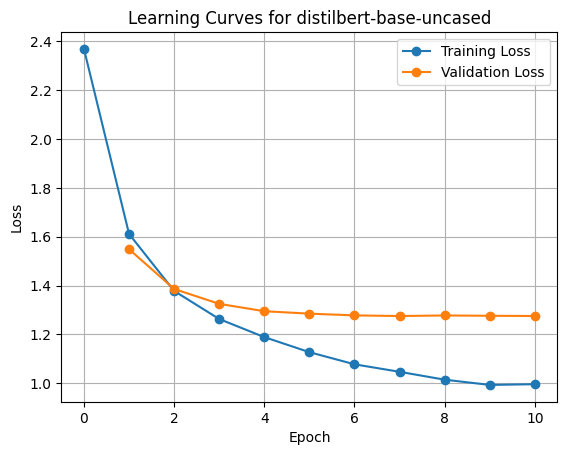

<ipython-input-9-6634c96594fe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_results['Epoch'] = model_results['Epoch'].round()


    Epoch  Training Loss
0     0.0       3.312163
1     1.0       2.686511
2     2.0       2.345010
3     3.0       2.146956
4     4.0       2.017202
5     5.0       1.935659
6     6.0       1.877492
7     7.0       1.838864
8     8.0       1.807742
9     9.0       1.793933
10   10.0       1.791103
   Epoch  Validation Loss
0    1.0         2.618005
1    2.0         2.296919
2    3.0         2.097950
3    4.0         1.980667
4    5.0         1.906923
5    6.0         1.848091
6    7.0         1.816996
7    8.0         1.793229
8    9.0         1.774655
9   10.0         1.772734


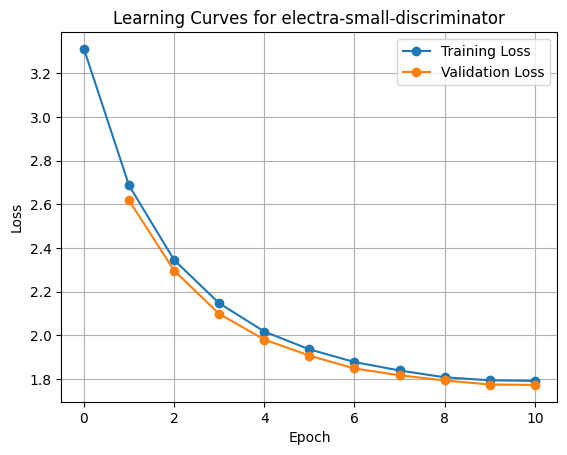

<ipython-input-9-6634c96594fe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_results['Epoch'] = model_results['Epoch'].round()


    Epoch  Training Loss
0     0.0       2.024663
1     1.0       1.476166
2     2.0       1.325908
3     3.0       1.235295
4     4.0       1.179914
5     5.0       1.134435
6     6.0       1.093636
7     7.0       1.070387
8     8.0       1.045630
9     9.0       1.028380
10   10.0       1.028723
   Epoch  Validation Loss
0    1.0         1.390942
1    2.0         1.296463
2    3.0         1.258284
3    4.0         1.224477
4    5.0         1.213935
5    6.0         1.200651
6    7.0         1.199525
7    8.0         1.194973
8    9.0         1.195733
9   10.0         1.178223


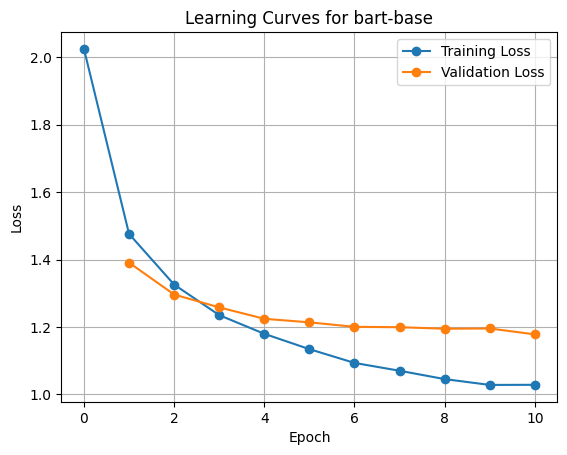

<ipython-input-9-6634c96594fe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_results['Epoch'] = model_results['Epoch'].round()


    Epoch  Training Loss
0     0.0       2.711674
1     1.0       1.882120
2     2.0       1.552103
3     3.0       1.399125
4     4.0       1.306754
5     5.0       1.239218
6     6.0       1.185130
7     7.0       1.143822
8     8.0       1.115480
9     9.0       1.092567
10   10.0       1.088750
   Epoch  Validation Loss
0    1.0         1.790925
1    2.0         1.524679
2    3.0         1.425209
3    4.0         1.373832
4    5.0         1.353421
5    6.0         1.346023
6    7.0         1.336798
7    8.0         1.324853
8    9.0         1.324021
9   10.0         1.308677


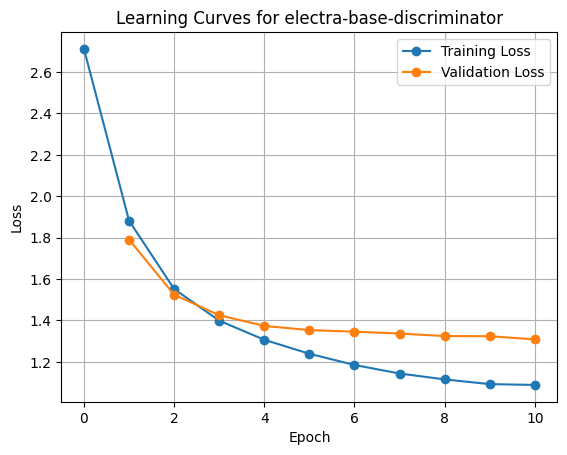

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to plot learning curves for all models
def plot_learning_curves(results_df):
    # Get unique model names
    model_names = results_df['Model'].unique()

    for model_name in model_names:
        model_results = results_df[results_df['Model'] == model_name]

        # Round the epoch values to ensure proper grouping
        model_results['Epoch'] = model_results['Epoch'].round()

        # Filter to get the last training loss entry per epoch
        avg_training_loss_per_epoch = model_results.dropna(subset=['Training Loss']).groupby('Epoch')['Training Loss'].mean().reset_index()
        last_validation_loss_per_epoch = model_results.dropna(subset=['Validation Loss']).groupby('Epoch')['Validation Loss'].last().reset_index()
        print(avg_training_loss_per_epoch)
        print(last_validation_loss_per_epoch)
        # Merge the training and validation losses
        merged_results = pd.merge(avg_training_loss_per_epoch, last_validation_loss_per_epoch, on='Epoch', how='outer')


        plt.plot(merged_results['Epoch'], merged_results['Training Loss'], label='Training Loss', marker='o')
        plt.plot(merged_results['Epoch'], merged_results['Validation Loss'], label='Validation Loss', marker='o')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Learning Curves for {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function to plot learning curves
plot_learning_curves(results_df)
